In [ ]:
import ctypes

In [ ]:
basic_dll = ctypes.CDLL('fourier_basic.so')

In [ ]:
basic_dll.density_fourier_capi_float.restype = ctypes.c_int
basic_dll.density_fourier_capi_float.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_long, ctypes.c_float, ctypes.c_float]
basic_dll.density_fourier_capi_double.restype = ctypes.c_int
basic_dll.density_fourier_capi_double.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_long, ctypes.c_double, ctypes.c_double]

In [4]:
import numpy as np

In [5]:
def density_fourier_float(data: np.array, hcount = 32):
    fp_data = np.ascontiguousarray(data, dtype = np.float32)
    scount = len(fp_data)
    re_harm, im_harm = np.zeros(hcount, dtype = np.float32), np.zeros(hcount, dtype = np.float32) 
    dmin, dmax = np.min(data), np.max(data)
    shift, basek = 0.5 * (dmax + dmin), 2 * np.pi / np.abs(dmax - dmin)
    res = basic_dll.density_fourier_capi_float(  \
        fp_data.ctypes.data_as(ctypes.c_void_p), \
        re_harm.ctypes.data_as(ctypes.c_void_p), \
        im_harm.ctypes.data_as(ctypes.c_void_p), \
        scount, hcount, shift, basek)
    assert res == 0
    return (re_harm, im_harm)

def density_fourier_double(data: np.array, hcount = 32):
    fp_data = np.ascontiguousarray(data, dtype = np.float64)
    scount = len(fp_data)
    re_harm, im_harm = np.zeros(hcount, dtype = np.float64), np.zeros(hcount, dtype = np.float64) 
    dmin, dmax = np.min(data), np.max(data)
    shift, basek = 0.5 * (dmax + dmin), 2 * np.pi / np.abs(dmax - dmin)
    res = basic_dll.density_fourier_capi_double( \
        fp_data.ctypes.data_as(ctypes.c_void_p), \
        re_harm.ctypes.data_as(ctypes.c_void_p), \
        im_harm.ctypes.data_as(ctypes.c_void_p), \
        scount, hcount, shift, basek)
    assert res == 0
    return (re_harm, im_harm)

def density_fourier(data: np.array, hcount = 32):
    if data.dtype == np.float32:
        return density_fourier_float(data, hcount)
    if data.dtype == np.float64:
        return density_fourier_double(data, hcount)
    return None

In [6]:
import matplotlib.pyplot as plt

In [7]:
basic_dll.evaluate_fourier_capi_float.restype = ctypes.c_float
basic_dll.evaluate_fourier_capi_float.argtypes = [ctypes.c_float, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_float, ctypes.c_float]
basic_dll.evaluate_fourier_capi_double.restype = ctypes.c_double
basic_dll.evaluate_fourier_capi_double.argtypes = [ctypes.c_double, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_double, ctypes.c_double]

In [8]:
def evaluate_fourier_float(arg: float, 
                           reharmonics: np.array, imharmonics: np.array, 
                           shift = 0.0, basek = np.pi) -> float:
    assert (imharmonics.ndim == 1) and (reharmonics.ndim == 1)
    assert imharmonics.shape == reharmonics.shape
    reh = np.ascontiguousarray(reharmonics, dtype = np.float32)
    imh = np.ascontiguousarray(imharmonics, dtype = np.float32)
    hcount = len(imh)
    return basic_dll.evaluate_fourier_capi_float(     \
                arg,                                  \
                reh.ctypes.data_as(ctypes.c_void_p),  \
                imh.ctypes.data_as(ctypes.c_void_p),  \
                hcount, shift, basek) / reharmonics[0]

def evaluate_fourier_double(arg: float, 
                            reharmonics: np.array, imharmonics: np.array, 
                            shift = 0.0, basek = np.pi) -> float:
    assert (imharmonics.ndim == 1) and (reharmonics.ndim == 1)
    assert imharmonics.shape == reharmonics.shape
    reh = np.ascontiguousarray(reharmonics, dtype = np.float64)
    imh = np.ascontiguousarray(imharmonics, dtype = np.float64)
    hcount = len(imh)
    return basic_dll.evaluate_fourier_capi_double(   \
                arg,                                  \
                reh.ctypes.data_as(ctypes.c_void_p),  \
                imh.ctypes.data_as(ctypes.c_void_p),  \
                hcount, shift, basek) / reharmonics[0]

def evaluate_fourier(arg: float, 
                     reharmonics: np.array, imharmonics: np.array, 
                     shift = 0.0, basek = np.pi):
    assert imharmonics.dtype == reharmonics.dtype
    if (imharmonics.dtype == np.float32) and (reharmonics.dtype == np.float32):
        return evaluate_fourier_float(arg, reharmonics, imharmonics, shift, basek)
    if (imharmonics.dtype == np.float64) and (reharmonics.dtype == np.float64):
        return evaluate_fourier_double(arg, reharmonics, imharmonics, shift, basek)
    return None

In [9]:
import pandas as pd

In [10]:
higgs = pd.read_csv('../data/HIGGS.csv.gz', header = None)

In [13]:
higgs.to_pickle('../data/higgs.pickle')

In [10]:
higgs = pd.read_pickle('../data/higgs.pickle')

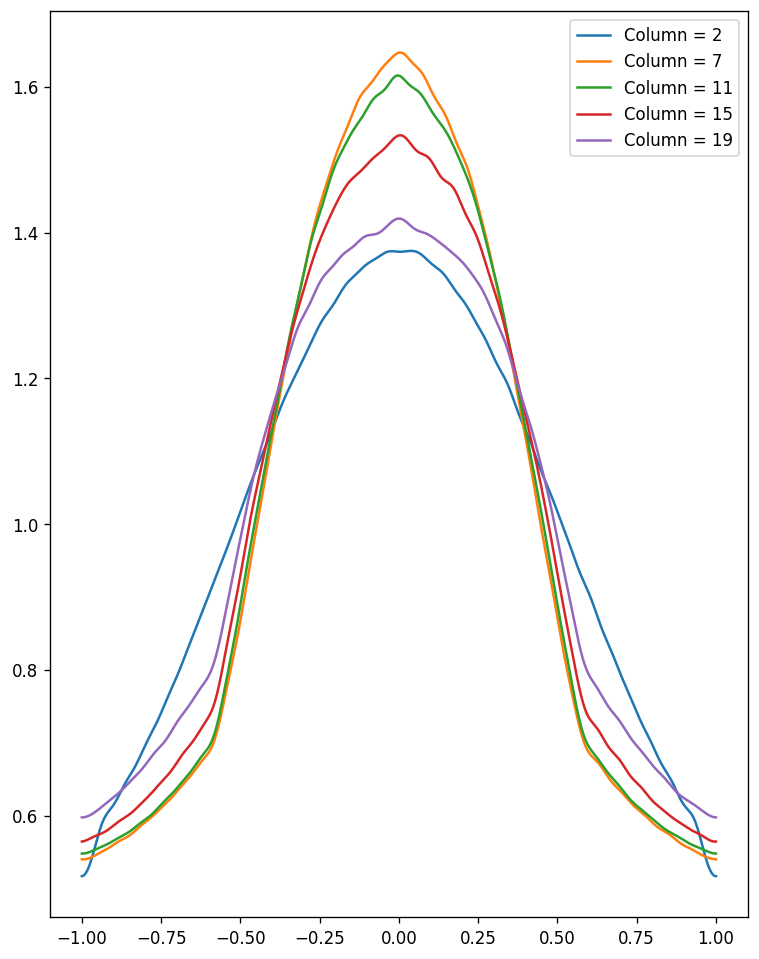

In [11]:
plt.figure(figsize = (7.5, 10), dpi = 120)
for c in [2, 7, 11, 15, 19]:
    reex, imex = density_fourier(higgs[c].to_numpy())
    xs = np.linspace(-1.0, +1.0, 1000)
    func = lambda x: evaluate_fourier(x, reex, imex)
    ys = np.array([func(x) for x in xs])
    plt.plot(xs, ys, label = f'Column = {c}')
plt.legend()

In [12]:
higgs.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [13]:
higgs.shape

(11000000, 29)

In [14]:
train_size = 10000000
train, test = higgs.iloc[:train_size, :], higgs.iloc[train_size:, :]
del higgs

In [15]:
train.shape, test.shape

((10000000, 29), (1000000, 29))

In [ ]:
train_true, train_false = train[train[0] == 1.0], train[train[0] == 0.0]

In [16]:
train_data, train_resp = train.iloc[:, 0], train.iloc[:, 1:]

In [17]:
train_data.shape, train_resp.shape

((10000000,), (10000000, 28))

In [ ]:
train_true